In [22]:
def setup(ax):
    ax.tick_params(direction='in', length=10, width=4, colors='black')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    #ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='minor', direction='in', width=2.00,length=5)
    ax.tick_params(which='minor', direction='in',width=2.00,length=5)
    ax.patch.set_alpha(0.0)

In [2]:
import jax
jax.config.update("jax_enable_x64", False)


In [3]:
import jax
print("JAX version:", jax.__version__)
print("Devices:", jax.devices())


JAX version: 0.7.0
Devices: [CpuDevice(id=0)]


In [4]:
import os

# Force JAX to use CPU **before** importing jax.numpy or any JAX code
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
print("JAX version:", jax.__version__)
print("Devices:", jax.devices())

JAX version: 0.7.0
Devices: [CpuDevice(id=0)]


In [5]:
def setup(ax):
    ax.tick_params(direction='in', length=10, width=4, colors='black')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    #ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='minor', direction='in', width=2.00,length=5)
    ax.tick_params(which='minor', direction='in',width=2.00,length=5)
    ax.patch.set_alpha(0.0)

In [6]:
import numpy as np
from datetime import datetime
from jax import config
# config.update("jax_traceback_filtering", "off")
from jax import block_until_ready
from jaxincell import simulation, load_parameters, diagnostics

input_parameters, solver_parameters = load_parameters('/Users/luis_lu/Desktop/UW-Madison/UWPlasma/hlu/JAX-in-Cell/examples/bump-on-tail.toml')

# Run the simulation
started = datetime.now()
output = block_until_ready(simulation(input_parameters, **solver_parameters))
print("Simulation done, elapsed:", datetime.now()-started)

# Post-process: segregate ions/electrons, compute energies, compute FFT
diagnostics(output)


***hello***
Length of the simulation box: 102.6 Debye lengths or 5.130000000097596 Skin Depths
Density of electrons: 743178397230894.4 m^-3
Electron temperature: 1277.4973794204607 eV
Ion temperature / Electron temperature: 1e-09
Debye length: 0.009746588693957116 m
Skin depth: 0.1949317738754338 m
Wavenumber * Debye length: 0.0
Pseudoparticles per cell: 1000.0
Pseudoparticle weight: 18579459930.772358
Steps at each plasma frequency: 7.797270955017352
Total time: 128.25000000243992 / plasma frequency
Number of particles on a Debye cube: 688099107.8018124
Relativistic gamma factor: Maximum 1.1390913062571921, Average 1.0089376906103924
Charge x External electric field x Debye Length / Temperature: 0.0



Running for 1,000 iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done, elapsed: 0:00:43.442596


In [41]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

__all__ = ['plot_combined_electrons']

def setup(ax):
    """
    Applies custom styling to the matplotlib axis, including larger 
    scientific notation multipliers.
    """
    ax.tick_params(direction='in', length=10, width=4, colors='black')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in', width=3.00, length=7, labelsize=24)
    ax.tick_params(which='minor', direction='in', width=2.00, length=5)
    ax.patch.set_alpha(0.0)
    
    # NEW: Make the "1e8" (scientific notation offset) bigger
    ax.xaxis.get_offset_text().set_fontsize(24)
    ax.yaxis.get_offset_text().set_fontsize(24)

def plot(output, frame=-1, direction="x"):
    """
    Plots a SINGLE phase space panel combining ALL electron species
    with large fonts and custom styling.
    """
    # -------- Basic Setup --------
    grid = output["grid"]
    time_array = output["time_array"] * output["plasma_frequency"]
    
    if frame < 0:
        frame = len(time_array) + frame
    
    current_time = time_array[frame]
    xmin, xmax = float(grid[0]), float(grid[-1])

    # -------- Direction Setup --------
    if len(direction) == 1 and direction in "xyz":
        direction1 = direction
        direction_index1 = {"x": 0, "y": 1, "z": 2}[direction1]
    else:
        direction1 = "x"
        direction_index1 = 0

    # -------- 1. Identify All Electron Species --------
    species_list = output.get("species", [])
    if not species_list:
        species_list = [
            {"name": "Electrons", 
             "positions": output.get("position_electrons"), 
             "velocities": output.get("velocity_electrons"), 
             "charge": -1.0}
        ]

    electron_species = []
    
    for i, sp in enumerate(species_list):
        name = sp.get("name", f"Species_{i}")
        charge = sp.get("charge", None)
        
        # Check if electron (by name or negative charge)
        is_electron = ("electron" in name.lower()) or (charge is not None and charge < 0)
        
        if is_electron:
            try:
                P_frame = sp["positions"][frame, :, direction_index1]
                V_frame = sp["velocities"][frame, :, direction_index1]
                
                electron_species.append({
                    "name": name,
                    "P": P_frame,
                    "V": V_frame
                })
            except (KeyError, IndexError, TypeError):
                continue

    if not electron_species:
        print("No electron species found.")
        return

    # -------- 2. Calculate Global Velocity Bounds --------
    all_velocities = [sp["V"] for sp in electron_species]
    
    global_max_v = 0.0
    for v in all_velocities:
        if v.size > 0:
            local_max = float(jnp.max(jnp.abs(v)))
            if local_max > global_max_v:
                global_max_v = local_max
    
    global_max_v = max(global_max_v, 1.0) 

    # -------- 3. Compute and Sum Histograms --------
    bins_x = len(grid)
    bins_v = max(min(len(grid), 111), 71)
    
    total_hist = jnp.zeros((bins_x, bins_v))
    species_names_included = []

    for sp in electron_species:
        species_names_included.append(sp["name"])
        hist, _, _ = jnp.histogram2d(
            sp["P"], sp["V"],
            bins=[bins_x, bins_v],
            range=[[xmin, xmax], [-global_max_v, global_max_v]]
        )
        total_hist += hist

    # -------- 4. Plot --------
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Apply styling (including the fix for 1e8 size)
    setup(ax)

    im = ax.imshow(
        total_hist.T, 
        aspect="auto", origin="lower", cmap="twilight",
        extent=[xmin, xmax, -global_max_v, global_max_v],
        vmin=0, vmax=jnp.max(total_hist)
    )

    species_str = ", ".join(species_names_included)
    
    ax.set_xlabel(f"Position {direction1} (m)", fontsize=24)
    ax.set_ylabel(f"Velocity {direction1} (m/s)", fontsize=24)
    
    # Add text box
    ax.text(0.02, 0.98, f"Species: {species_str}", transform=ax.transAxes,
            ha="left", va="top", fontsize=18, color="black",
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', linewidth=2))

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20, width=2, length=5)
    
    # Make colorbar offset text bigger too (if scientific notation appears there)
    cbar.ax.yaxis.get_offset_text().set_fontsize(20)
    
    cbar.set_label("Count", fontsize=24)
    cbar.outline.set_linewidth(2)

    plt.tight_layout()
    plt.show()

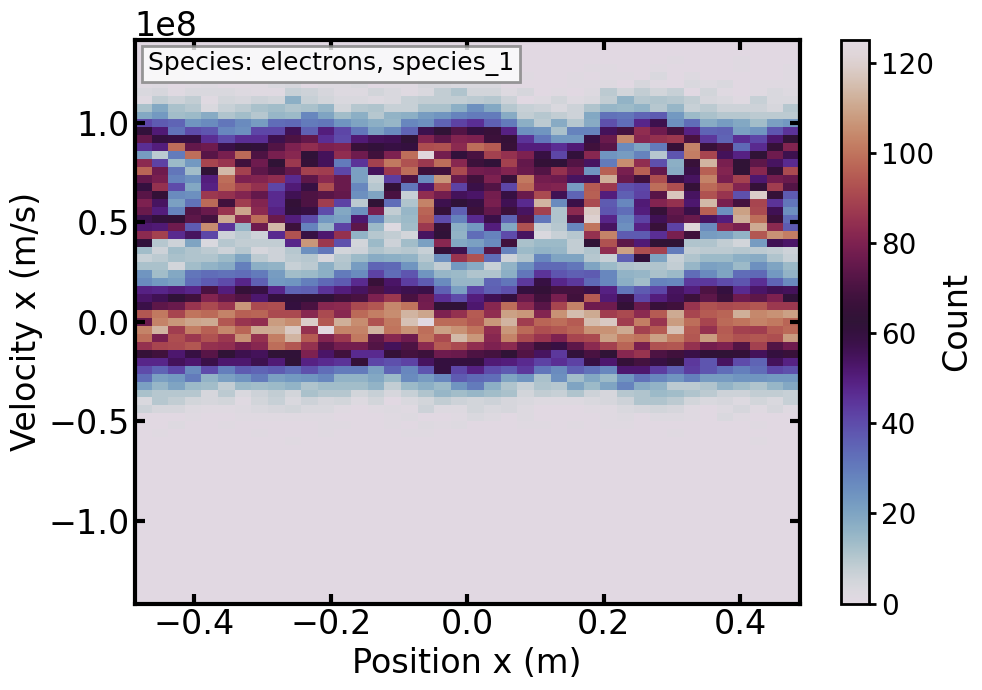

In [42]:
plot(output,545)

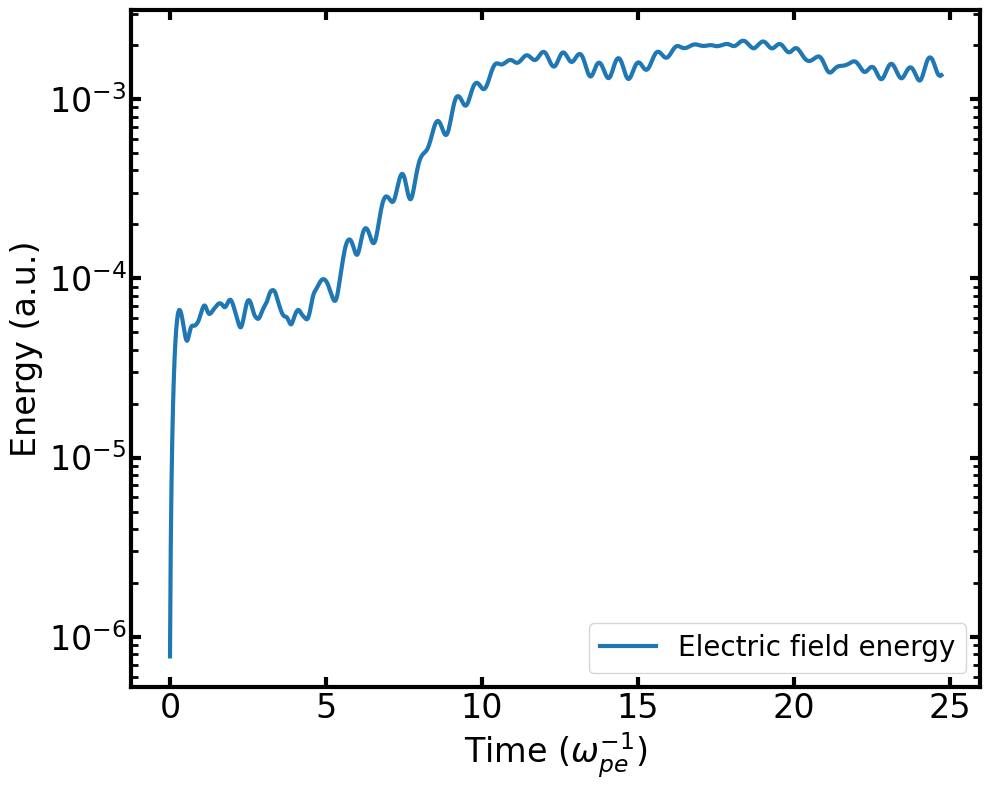

In [44]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- Extract data ---
E = output["electric_field_energy"]
Energy = output["total_energy"]
time = jnp.arange(len(E))

# --- Compute relative energy conservation ---
E0 = Energy[0]
rel_energy = (Energy - E0) / E0

# --- Plot section ---
fig, ax1 = plt.subplots(figsize=(10, 8))
time_o = time / 40.40610178208843

# Plot field energies
ax1.semilogy(time_o, E, label="Electric field energy", lw=3, color="C0")
# ax1.semilogy(time_o, Energy, label="Total energy", lw=3, color="C2")
ax1.set_xlabel("Time ($\\omega_{pe}^{-1}$)", fontsize=24)
ax1.set_ylabel("Energy (a.u.)", fontsize=24)
ax1.legend(fontsize=20)


# --- Apply your style and layout ---
setup(ax1)
fig.tight_layout()
plt.show()
